In [9]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

from bearfacedetection.xml_parser import load_xml

# For type hints
Contour = np.ndarray
Mask = np.ndarray
Polygon = np.ndarray

In [25]:
def load_image(image_data: dict):
    image_filepath = image_data["filepath"]
    image = cv2.imread(str(image_filepath))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def normalize_polygon(polygon, W: int, H: int):
    """`polygon`: numpy array of shape (_,2) containing the polygon x,y
    coordinates.

    `W`: int - width of the image / mask
    `H`: int - height of the image / mask

    returns a numpy array of shape `polygon.shape` with coordinates that are
    normalized between 0-1.

    Will throw an assertion error if all values of the result do not lie in 0-1.
    """
    copy = np.copy(polygon)
    copy = copy.astype(np.float16)
    copy[:, 0] *= 1 / W
    copy[:, 1] *= 1 / H

    assert (
        (copy >= 0) & (copy <= 1)
    ).all(), f"normalized_polygon values are not all in range 0-1, got: {copy}"

    return copy


def contours_to_polygons(contours: list[Contour]) -> list[Polygon]:
    """Turn a list of contours into a list of polygons."""
    polygons = []
    for contour in contours:
        polygon_list = []
        for point in contour:
            x, y = point[0]
            polygon_list.append(np.array([x, y]))
        polygon = np.array(polygon_list)
        polygons.append(polygon)
    return polygons


def is_contour_area_large_enough(contour: Contour, threshold: int = 200) -> bool:
    return cv2.contourArea(contour) > threshold


def mask_to_contours(mask: Mask) -> list[Contour]:
    """Given a mask, it returns its contours."""
    # Loading the mask in grey, only format supported by cv2.findContours
    mask_grey = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(
        mask_grey, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    # Only keep the areas that are big enough
    valid_contours = [
        contour for contour in contours if is_contour_area_large_enough(contour)
    ]
    return valid_contours


def display_contours(mask: Mask, contours: list[Contour]) -> None:
    """Display the contours information, useful for debugging."""
    N = len(contours)
    plt.subplots(1, N + 1, figsize=(15, 15))

    plt.subplot(1, N + 1, 1)
    plt.imshow(mask)
    plt.title("Mask")

    color = (0, 0, 255)
    thickness = 10
    for i, contour in enumerate(contours):
        image_black = np.zeros(mask.shape, dtype=np.uint8)
        image_contour = cv2.drawContours(image_black, [contour], -1, color, thickness)
        plt.subplot(1, N + 1, i + 2)
        plt.imshow(image_contour)
        plt.title(f"Contour {i}")

    plt.show()


# Yolov8 PyTorch TXT format
def stringify_polygon(polygon: Polygon) -> str:
    """Turns a polygon nd_array into a string in the right YOLOv8 format."""
    return " ".join([f"{x} {y}" for (x, y) in polygon])


def filepath_to_ndarray(filepath: Path) -> np.ndarray:
    return cv2.imread(str(filepath))


def mask_filepath_to_yolov8_format_string(filepath: Path) -> str:
    """Given a `filepath` for an individual mask, it returns a yolov8 format
    string describing the polygons for the segmentation tasks."""
    mask = filepath_to_ndarray(filepath)
    label_class = 0
    H, W, _ = mask.shape
    contours = mask_to_contours(mask)
    polygons = contours_to_polygons(contours)
    normalized_polygons = [normalize_polygon(p, W, H) for p in polygons]
    return "\n".join(
        [f"{label_class} {stringify_polygon(p)}" for p in normalized_polygons]
    )

In [7]:
base_path = Path('../../data/01_raw/BearID/')
label_path = base_path / 'images_train_without_bc.xml'
head_dir = Path('../../data/04_feature/bearfacesegmentation/sam/head/train/')
xml_data = load_xml(base_path=base_path, filepath=label_path)

In [5]:
xml_data["images"][0]

{'filepath': PosixPath('../../data/01_raw/BearID/images/brooksFalls/je_201708/bf_755/755-scare-d-bear-near-the-north-side-of-brooks-falls_9237775339_o.jpg'),
 'bboxes': [{'top': 1059,
   'left': 1172,
   'width': 200,
   'height': 200,
   'parts': {'htop': {'x': 1283, 'y': 1068},
    'lear': {'x': 1335, 'y': 1080},
    'rear': {'x': 1228, 'y': 1084},
    'nose': {'x': 1279, 'y': 1197},
    'leye': {'x': 1324, 'y': 1132},
    'reye': {'x': 1246, 'y': 1133}}}],
 'size': {'width': 2000, 'height': 1500}}

In [8]:
head_dir.exists()

True

In [12]:
masks_filepaths = [head_dir / filename for filename in os.listdir(head_dir)]
stem_to_mask_filepath = {filepath.stem: filepath for filepath in masks_filepaths}

In [13]:
stem_to_mask_filepath

{'P1140838': PosixPath('../../data/04_feature/bearfacesegmentation/sam/head/train/P1140838.png'),
 '747-6': PosixPath('../../data/04_feature/bearfacesegmentation/sam/head/train/747-6.png'),
 '813-nostril-bear_14999717438_o': PosixPath('../../data/04_feature/bearfacesegmentation/sam/head/train/813-nostril-bear_14999717438_o.png'),
 '2015CF_beadnose-409_20775804440_o': PosixPath('../../data/04_feature/bearfacesegmentation/sam/head/train/2015CF_beadnose-409_20775804440_o.png'),
 'P1260531': PosixPath('../../data/04_feature/bearfacesegmentation/sam/head/train/P1260531.png'),
 'P1200551': PosixPath('../../data/04_feature/bearfacesegmentation/sam/head/train/P1200551.png'),
 'P1200225': PosixPath('../../data/04_feature/bearfacesegmentation/sam/head/train/P1200225.png'),
 '289-4': PosixPath('../../data/04_feature/bearfacesegmentation/sam/head/train/289-4.png'),
 'P1250088': PosixPath('../../data/04_feature/bearfacesegmentation/sam/head/train/P1250088.png'),
 'P1150830': PosixPath('../../data/0

In [35]:
idx = 47
image_data = xml_data["images"][idx]
image = load_image(image_data)
mask_filepath = stem_to_mask_filepath.get(image_data["filepath"].stem)
mask = filepath_to_ndarray(mask_filepath)

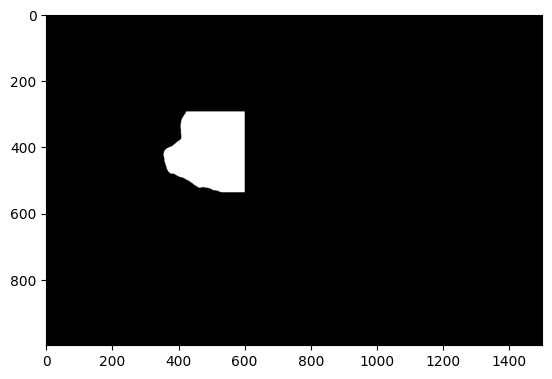

In [36]:
plt.imshow(mask)

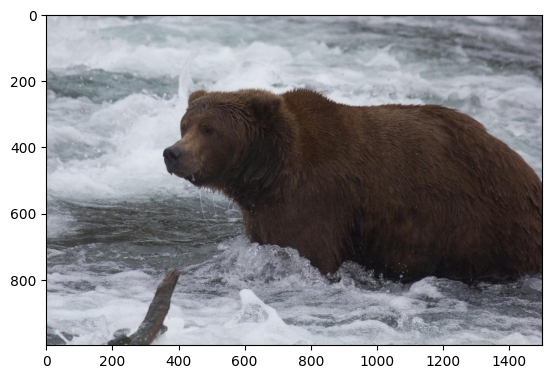

In [37]:
plt.imshow(image)

In [38]:
contours = mask_to_contours(mask)
polygons = contours_to_polygons(contours)

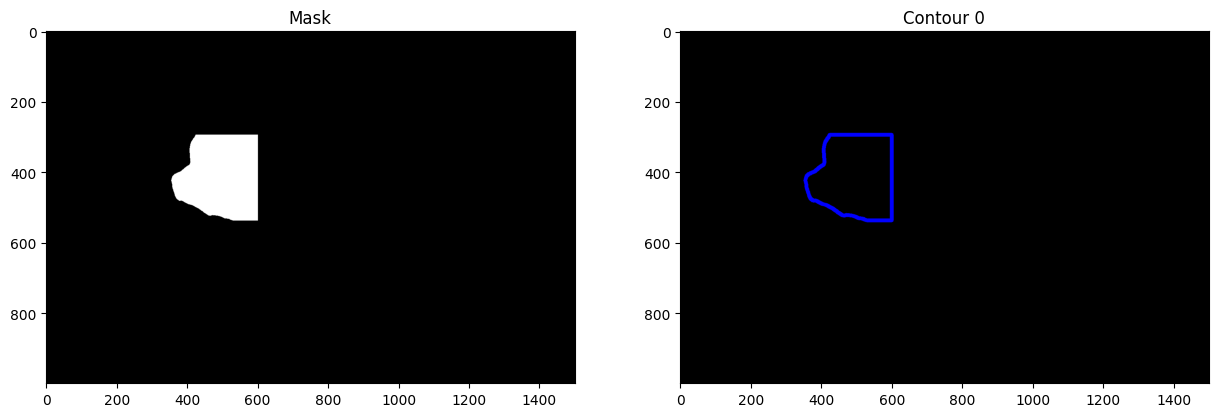

In [39]:
display_contours(mask, contours)

In [34]:
mask_filepath_to_yolov8_format_string(mask_filepath)

'0 0.54296875 0.1954345703125 0.54296875 0.4462890625 0.68408203125 0.4462890625 0.68408203125 0.445556640625 0.68505859375 0.444091796875 0.68505859375 0.443359375 0.68603515625 0.44189453125 0.68603515625 0.441162109375 0.6865234375 0.4404296875 0.6865234375 0.439697265625 0.68701171875 0.43896484375 0.68701171875 0.438232421875 0.6875 0.4375 0.6875 0.436767578125 0.68798828125 0.43603515625 0.68798828125 0.435302734375 0.6884765625 0.4345703125 0.6884765625 0.43310546875 0.68896484375 0.432373046875 0.68896484375 0.430908203125 0.689453125 0.43017578125 0.689453125 0.429443359375 0.68994140625 0.428466796875 0.68994140625 0.427001953125 0.6904296875 0.42626953125 0.6904296875 0.418212890625 0.68994140625 0.41748046875 0.68994140625 0.409423828125 0.689453125 0.40869140625 0.689453125 0.400634765625 0.68896484375 0.39990234375 0.68896484375 0.3955078125 0.6884765625 0.39453125 0.6884765625 0.390869140625 0.68798828125 0.39013671875 0.68798828125 0.38720703125 0.6875 0.386474609375 0.